## Galaxies and quasars

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score
from astroML.utils import completeness_contamination
from astroML.classification import GMMBayes
import corner

In [2]:
data = pd.read_csv("../solutions/galaxyquasar.csv")

In [3]:
#Define the colors

color_ug = np.array(data["u"] - data["g"])
color_gr = np.array(data["g"] - data["r"])
color_ri = np.array(data["r"] - data["i"])
color_iz = np.array(data["i"] - data["z"])
classes = np.array(data["class"] == "QSO", dtype=int)

ug_ml = color_ug[:, np.newaxis]
gr_ml = color_gr[:, np.newaxis]
ri_ml = color_ri[:, np.newaxis]
iz_ml = color_iz[:, np.newaxis]

#Associate the colors with their names

colors = np.vstack((color_ug, color_gr, color_ri, color_iz)).T
c_names = ["u - g", "g - r", "r - i", "i - z"]
cd = dict(zip(c_names, colors.T))

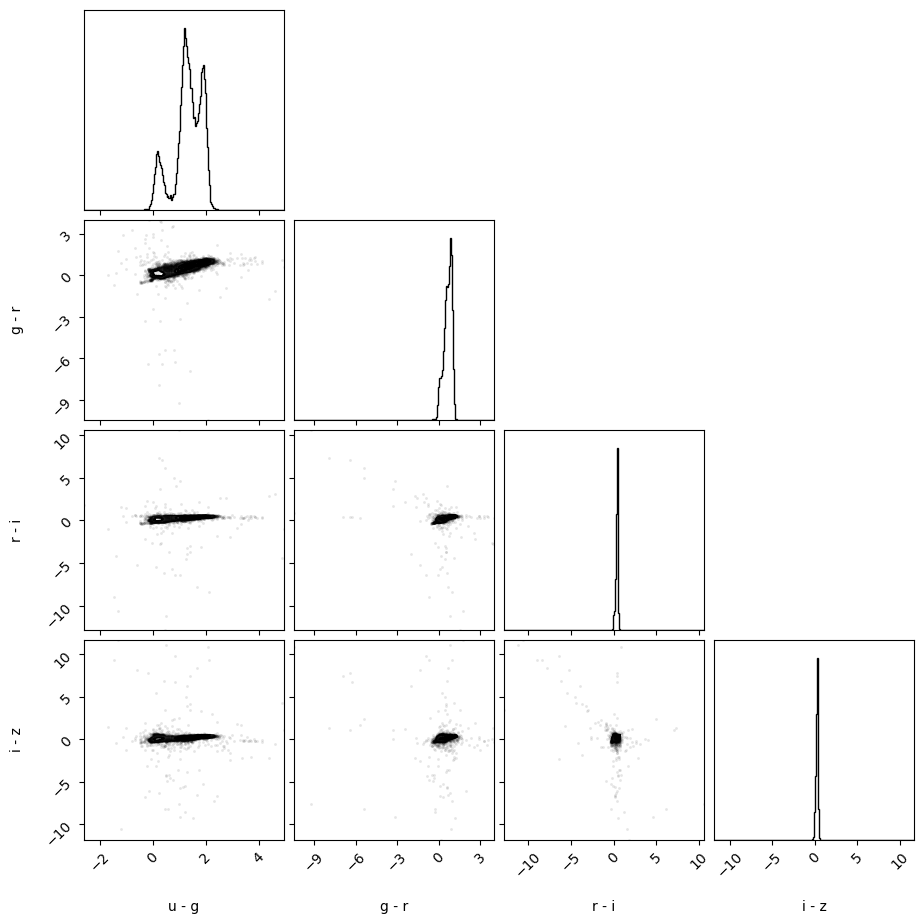

In [8]:
fig_corner = corner.corner(colors, bins=np.sqrt(len(colors[:, 0])), labels=list(cd.keys()))

The u-g color shows the bimodality galaxy-quasar the most clearly

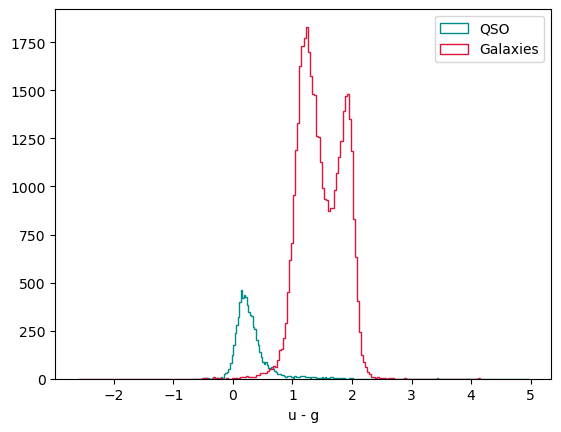

In [10]:
plt.figure()
plt.hist(cd["u - g"][classes == 1], histtype="step", bins="fd", color="darkcyan", label="QSO")
plt.hist(cd["u - g"][classes == 0], histtype="step", bins="fd", color="crimson", label="Galaxies")
plt.xlabel("u - g")
plt.legend()

In [7]:
train_X, test_X, train_y, test_y = train_test_split(colors, classes, train_size=0.8)

## Classification and ROC curves with different classifiers

Gaussian naive bayes
Accuracy (colors: 1) = 0.9807
Accuracy (colors: 2) = 0.9739
Accuracy (colors: 3) = 0.9734
Accuracy (colors: 4) = 0.9728


QDA
Accuracy (colors: 1) = 0.9807
Accuracy (colors: 2) = 0.9802
Accuracy (colors: 3) = 0.9793
Accuracy (colors: 4) = 0.9789


Gaussian mixture classifier
Accuracy (gaussians = 1) = 0.9789
Accuracy (gaussians = 3) = 0.9703
Accuracy (gaussians = 5) = 0.9802
Accuracy (gaussians = 7) = 0.98
Accuracy (gaussians = 9) = 0.979
Accuracy (gaussians = 11) = 0.9812
Accuracy (gaussians = 13) = 0.9828
Accuracy (gaussians = 15) = 0.9813


K neighbors
Accuracy (K = 1) = 0.9786
Accuracy (K = 3) = 0.9822
Accuracy (K = 5) = 0.985
Accuracy (K = 7) = 0.9851
Accuracy (K = 9) = 0.985
Accuracy (K = 11) = 0.9849


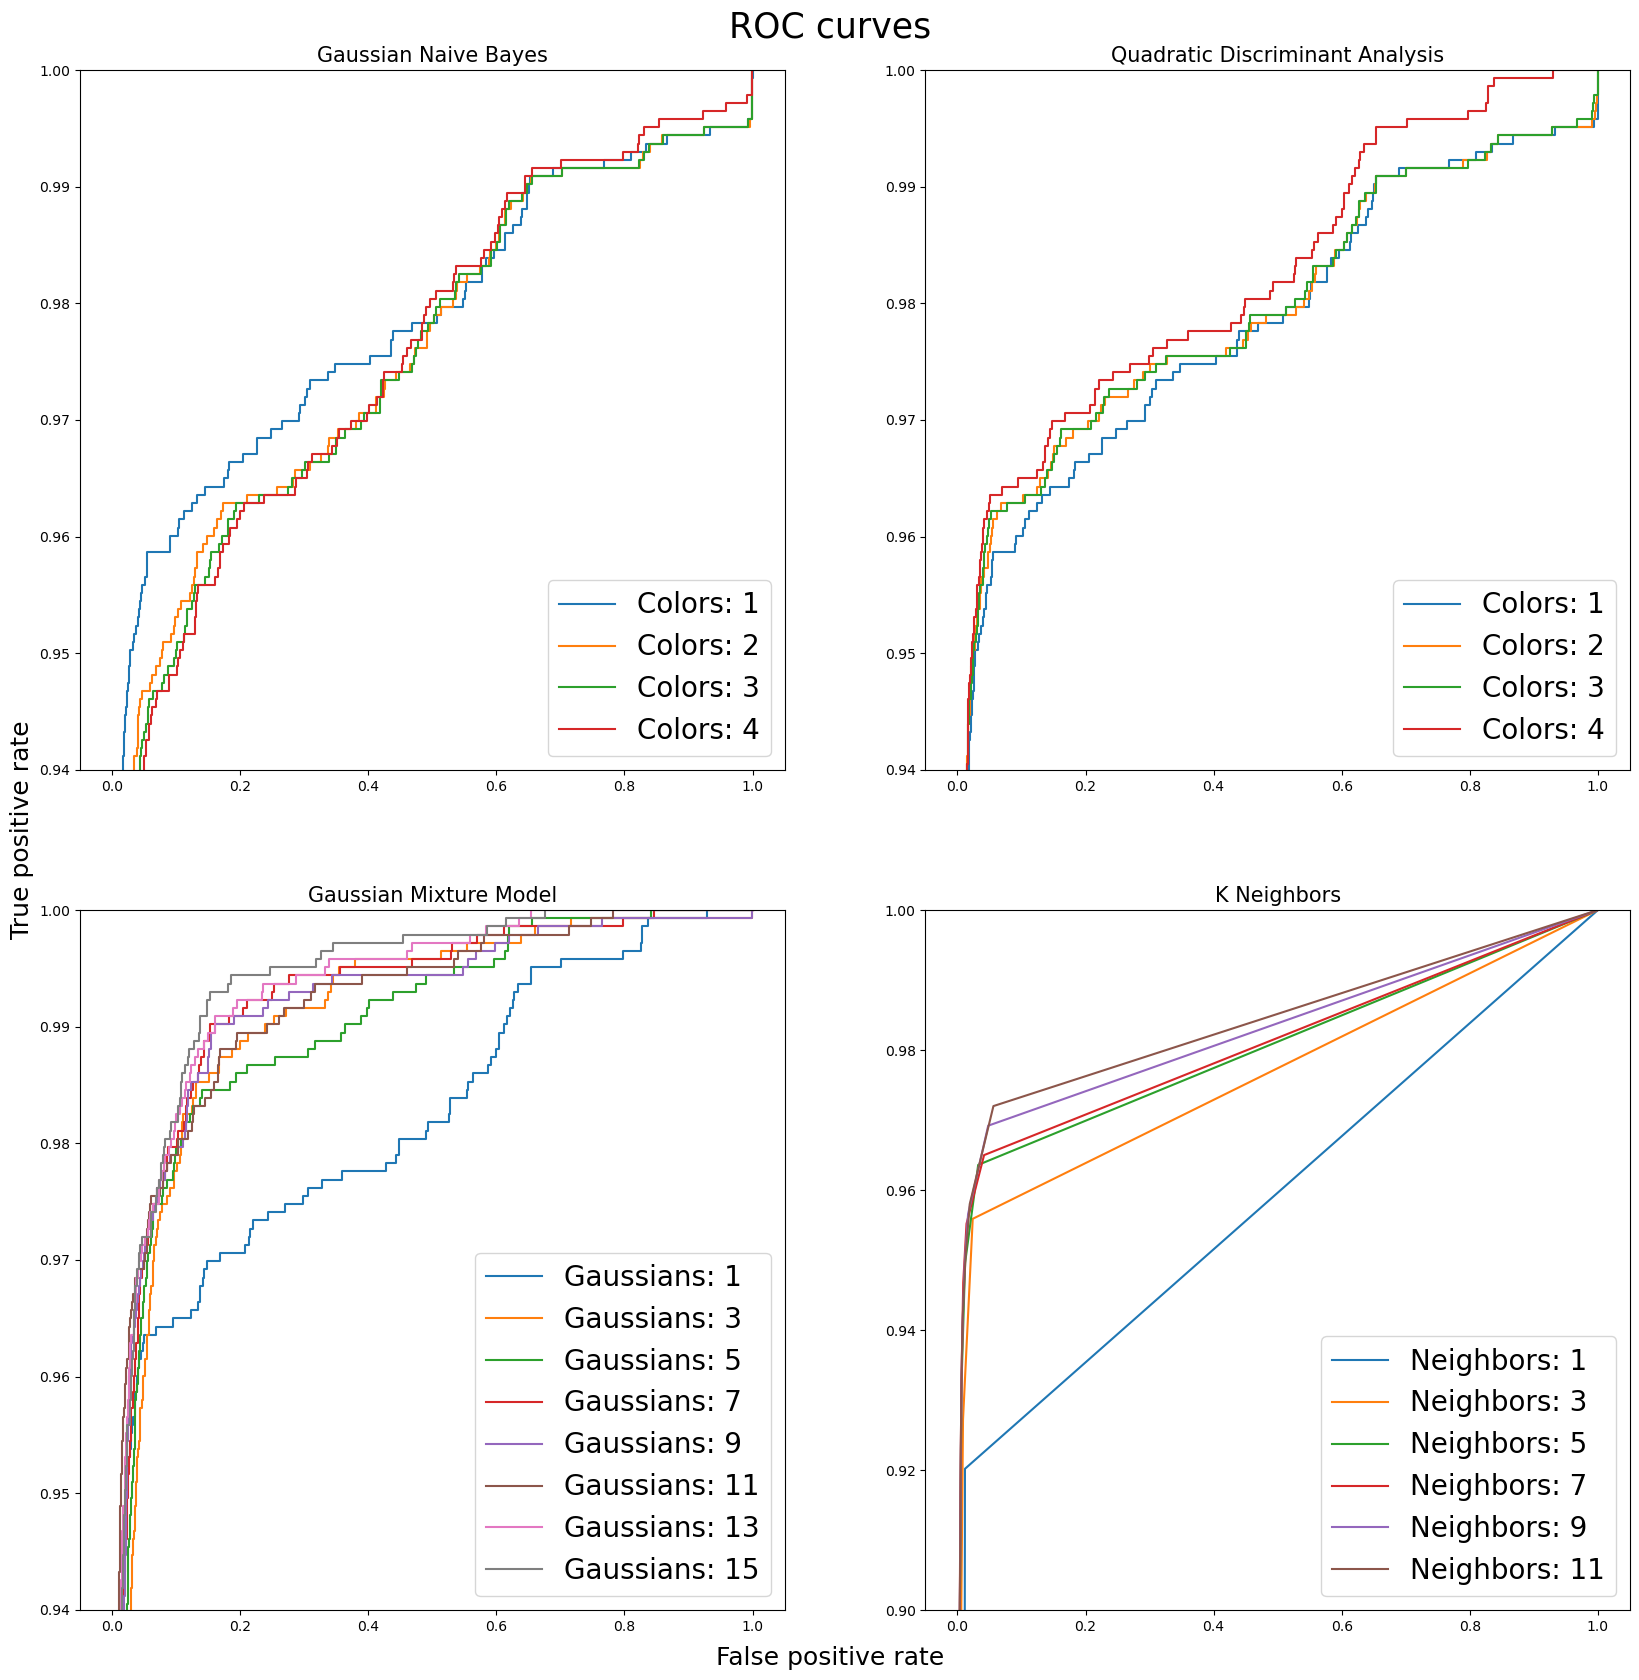

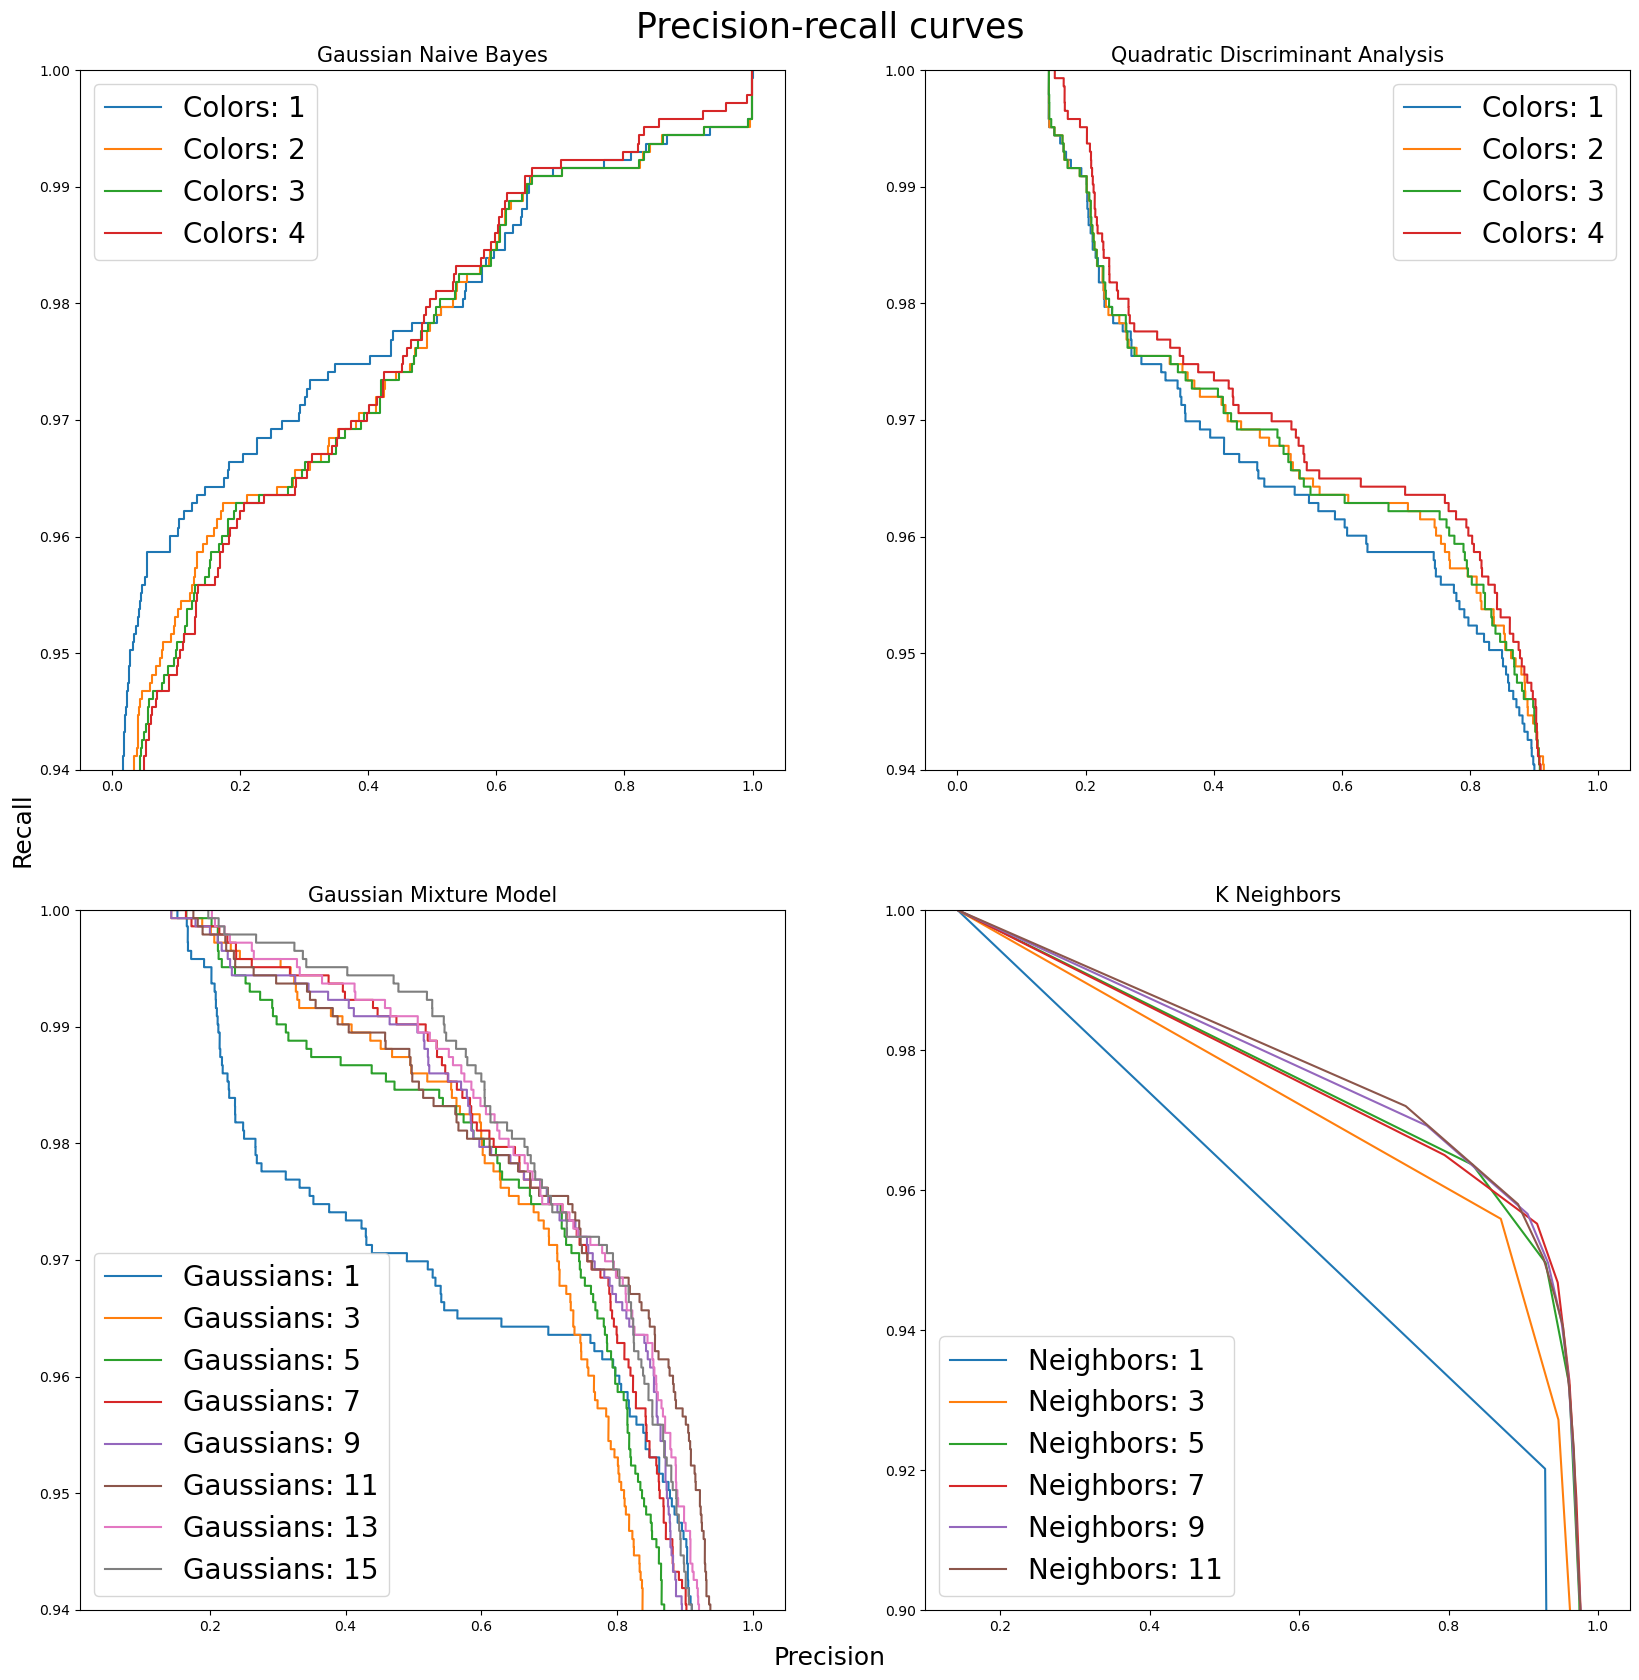

In [32]:
#General classification function
def ClassifyData(train_X, train_y, test_X, test_y, clf):
    clf.fit(train_X, train_y)
    prob = clf.predict_proba(test_X)[:, 1]
    pred = clf.predict(test_X)
    fpr, tpr, th = roc_curve(test_y, prob)
    precision, recall, _ = precision_recall_curve(test_y, prob)

    return fpr, tpr, th, pred, prob, precision, recall

#For ROC curves
fig, axes = plt.subplots(2, 2, figsize=(20, 20))    
fig.suptitle("ROC curves", size=25, y=0.91)
fig.supxlabel("False positive rate", size=18, y=0.08)
fig.supylabel("True positive rate", size=18, x=0.09)

#For precision-recall curves
fig_pr, axes_pr = plt.subplots(2, 2, figsize=(20, 20))    
fig_pr.suptitle("Precision-recall curves", size=25, y=0.91)
fig_pr.supxlabel("Precision", size=18, y=0.08)
fig_pr.supylabel("Recall", size=18, x=0.09)

#Gaussian Naive Bayes
print("Gaussian naive bayes")

for i in range(0, 4):
    fpr, tpr, th, pred, prob, prec, rec = ClassifyData(train_X[:, 0:i+1], train_y, test_X[:, 0:i+1], test_y, GaussianNB())
    print("Accuracy (colors: " + str(i + 1) + ") = " + str(accuracy_score(test_y, pred)))

    #ROC curves
    axes[0, 0].plot(fpr, tpr, label="Colors: " + str(i + 1))
    axes[0, 0].set_title("Gaussian Naive Bayes", size=15)
    axes[0, 0].set_ylim(0.94, 1)
    axes[0, 0].legend(prop={"size": 20}, loc="lower right")

    #Precision-Recall curves
    axes_pr[0, 0].plot(fpr, tpr, label="Colors: " + str(i + 1))
    axes_pr[0, 0].set_title("Gaussian Naive Bayes", size=15)
    axes_pr[0, 0].set_ylim(0.94, 1)
    axes_pr[0, 0].legend(prop={"size": 20})

print("\n")

#Quadratic Discriminant Analysis
print("QDA")

for i in range(0, 4):
    fpr, tpr, th, pred, prob, prec, rec = ClassifyData(train_X[:, 0:i+1], train_y, test_X[:, 0:i+1], test_y, QuadraticDiscriminantAnalysis())
    print("Accuracy (colors: " + str(i + 1) + ") = " + str(accuracy_score(test_y, pred)))

    #ROC curves
    axes[0, 1].plot(fpr, tpr, label="Colors: " + str(i + 1))
    axes[0, 1].set_title("Quadratic Discriminant Analysis", size=15)
    axes[0, 1].set_ylim(0.94, 1)
    axes[0, 1].legend(prop={"size": 20}, loc="lower right")

    #Precision-Recall curves
    axes_pr[0, 1].plot(prec, rec, label="Colors: " + str(i + 1))
    axes_pr[0, 1].set_title("Quadratic Discriminant Analysis", size=15)
    axes_pr[0, 1].set_ylim(0.94, 1)
    axes_pr[0, 1].legend(prop={"size": 20})

print("\n")

#Gaussian Mixture Model
print("Gaussian mixture classifier")

acc_gauss = []

for idx, i in enumerate(range(0, 15, 2)):
    fpr, tpr, th, pred, prob, prec, rec = ClassifyData(train_X, train_y, test_X, test_y, GMMBayes(n_components=i+1))

    #Store the accuracy for a given number of gaussians
    acc_gauss.append((i + 1, accuracy_score(test_y, pred)))
    print("Accuracy (gaussians = " + str(i + 1) + ") = " + str(acc_gauss[idx][1]))

    #ROC curves
    axes[1, 0].plot(fpr, tpr, label="Gaussians: " + str(i + 1))
    axes[1, 0].set_title("Gaussian Mixture Model", size=15)
    axes[1, 0].set_ylim(0.94, 1)
    axes[1, 0].legend(prop={"size": 20}, loc="lower right")

    #Precision-Recall curves
    axes_pr[1, 0].plot(prec, rec, label="Gaussians: " + str(i + 1))
    axes_pr[1, 0].set_title("Gaussian Mixture Model", size=15)
    axes_pr[1, 0].set_ylim(0.94, 1)
    axes_pr[1, 0].legend(prop={"size": 20})

print("\n")

#K Neighbors
print("K neighbors")

for i in range(0, 12, 2):
    fpr, tpr, th, pred, prob, prec, rec = ClassifyData(train_X, train_y, test_X, test_y, KNeighborsClassifier(n_neighbors=i+1))
    print("Accuracy (K = " + str(i + 1) + ") = " + str(accuracy_score(test_y, pred)))

    #ROC curves
    axes[1, 1].plot(fpr, tpr, label="Neighbors: " + str(i + 1))
    axes[1, 1].set_title("K Neighbors", size=15)
    axes[1, 1].set_ylim(0.9, 1)
    axes[1, 1].legend(prop={"size": 20}, loc="lower right")

    #Precision-Recall curves
    axes_pr[1, 1].plot(prec, rec, label="Neighbors: " + str(i + 1))
    axes_pr[1, 1].set_title("K Neighbors", size=15)
    axes_pr[1, 1].set_ylim(0.9, 1)
    axes_pr[1, 1].legend(prop={"size": 20})

The GMM and K nearest neighbors classifiers have similar accuracy, higher than NB and QDA even for low numbers of gaussians and K (using all colors). Also, seems like the NB and QDA classifiers perform worse when more and more colors are used.

## Classification with GMMBayes only

Accuracy (colors = 1) = 0.9811
AUC (colors = 1) = 0.9613912309530454


Accuracy (colors = 2) = 0.9827
AUC (colors = 2) = 0.9640490761656798


Accuracy (colors = 3) = 0.9844
AUC (colors = 3) = 0.9653299629910366


Accuracy (colors = 4) = 0.9851
AUC (colors = 4) = 0.9668875100586278




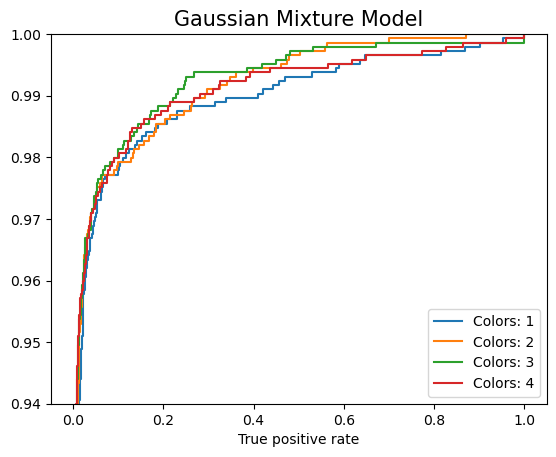

In [15]:
plt.figure()

#Select the GMM model with the best accuracy

acc_gauss = np.array(acc_gauss)
best_gauss = int(acc_gauss[np.argmax(acc_gauss[:, 1])][0])

for i in range(1, 5):
    #Take number of gaussians with best accuracy score
    fpr, tpr, th, pred, prob = ClassifyData(train_X[:, 0:i+1], train_y, test_X[:, 0:i+1], test_y, GMMBayes(n_components=best_gauss)) 
    print("Accuracy (colors = " + str(i) + ") = " + str(accuracy_score(test_y, pred)))
    print("AUC (colors = " + str(i) + ") = " + str(roc_auc_score(test_y, pred)))
    print("\n")
    
    plt.plot(fpr, tpr, label="Colors: " + str(i))
    plt.title("Gaussian Mixture Model", size=15)
    plt.xlabel("False positive rate")
    plt.xlabel("True positive rate")
    plt.ylim(0.94, 1)
    plt.legend(loc="lower right")

Three colors improve the classification performance, and the accuracy and AUC with four are similar to three

Accuracy = 0.9844
AUC = 0.9673395473615428
Confusion matrix: 
[[8479   74]
 [  82 1365]]


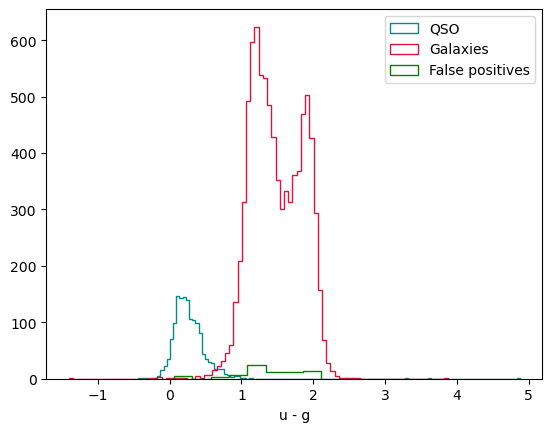

In [17]:
#Evaluate confusion matrix and overall performance on the test set with all colors

fpr, tpr, th, pred, prob = ClassifyData(train_X, train_y, test_X, test_y, GMMBayes(best_gauss)) 
fp = np.where(pred[test_y == 0] == 1)
accuracy = accuracy_score(test_y, pred)
AUC = roc_auc_score(test_y, pred)
C = confusion_matrix(test_y, pred)

print("Accuracy = " + str(accuracy))
print("AUC = " + str(AUC))
print("Confusion matrix: \n" + str(C))

#Plot histogram to label quasars and galaxies 

plt.figure()
plt.hist(test_X[:, 0][pred == 1], histtype="step", bins="fd", color="darkcyan", label="QSO")
plt.hist(test_X[:, 0][pred == 0], histtype="step", bins="fd", color="crimson", label="Galaxies")
plt.hist(test_X[:, 0][fp], histtype="step", bins="fd", color="green", label="False positives")
plt.xlabel("u - g")
plt.legend()